# All-optical control

In this tutorial we'll see how to
 - configure and inject a microscope for two-photon imaging and stimulation
 - inject a calcium indicator for neurons visible to the microscope
 - set up two-photon optogenetics by 
   - injecting an opsin with an extended action spectrum and 
   - injecting a 2P light source targeting neurons imaged by the microscope

## Preamble

In [ ]:
import brian2.only as b2
from brian2 import np
import cleo
from cleo import opto, imaging, light
import matplotlib.pyplot as plt

# slightly faster than numpy in this case
b2.prefs.codegen.target = "cython"

# for reproducibility
rng = np.random.default_rng(18010630)
cleo.utilities.set_seed(18501224)

cleo.utilities.style_plots_for_docs()

## Brian network setup
All we need are LIF neurons that will spike in response to photostimulation for us to see the resulting fluorescence traces.

In [ ]:
ng = b2.NeuronGroup(
    200,
    """dv/dt = (-(v - E_L) + Rm*Iopto) / tau_m : volt
    Iopto : amp""",
    threshold="v > -50*mV",
    reset="v=E_L",
    namespace={
        "tau_m": 20 * b2.ms,
        "Rm": 500 * b2.Mohm,
        "E_L": -70 * b2.mV,
    },
)
ng.v = -70 * b2.mV
cleo.coords.assign_coords_rand_rect_prism(ng, [-0.2, 0.2], [-0.2, 0.2], [0, 0.4])
sim = cleo.CLSimulator(b2.Network(ng))

## Microscope configuration

By default a scope selects neurons based on focus depth and assigns them a signal-to-noise ratio (SNR) based on soma size.
(Larger cells' SNR decays more slowly with distance from the focal plane.)
`focus_depth` and `soma_radius` are taken from scope parameters but can be overridden on injection.

We'll use GCaMP6f as our indicator and leave the default parameters, though those can be changed in the function call {func}`~cleo.imaging.gcamp6f`.

In [ ]:
scope = imaging.Scope(
    focus_depth=100 * b2.um,
    img_width=500 * b2.um,
    sensor=imaging.gcamp6f(),
)

Heterogeneous expression is simulated by providing a `rho_rel_generator` function that takes the number of neurons as an argument and returns a vector of relative expression levels.
This is done on scope injection (as opposed to sensor injection afterward) because the scope needs this information to select ROIs with sufficiently high SNR.

In [ ]:
expr_level_gen = lambda n: rng.lognormal(0, 0.2, n)
sim.inject(scope, ng, rho_rel_generator=expr_level_gen)  # uses scope's parameters
# optional overrides (we'll use a small soma to intentionally get few targets)
sim.inject(
    scope,
    ng,
    focus_depth=200 * b2.um,
    soma_radius=5 * b2.um,
    rho_rel_generator=expr_level_gen,
)

CLSimulator(io_processor=None, devices={Scope(name='Scope', save_history=True, sensor=GECI(name='GCaMP6f', save_history=True, model='\n            dCa/dt = -gamma * (Ca - Ca_rest) / (1 + kappa_S + kappa_B) : mmolar (clock-driven)\n            kappa_B = B_T * K_d / (Ca + K_d)**2 : 1\n\n            CaB_active = Ca_rest + b : mmolar  # add tiny bit to avoid /0\n            db/dt = beta : mmolar (clock-driven)\n            lam = 1/tau_off + 1/tau_on : 1/second\n            kap = 1/tau_off : 1/second\n            dbeta/dt = (                    # should be M/s/s\n                A * (lam - kap) * (Ca - Ca_rest)  # M/s/s\n                - (kap + lam) * beta        # M/s/s\n                - kap * lam * b    # M/s/s\n            ) : mmolar/second (clock-driven)\n            \nexc_factor = 1 : 1\n\n            dFF_baseline = 1 / (1 + (K_d / Ca_rest) ** n_H) : 1\n            dFF = exc_factor * rho_rel * dFF_max  * (\n                1 / (1 + (K_d / CaB_active) ** n_H)\n                - dFF_ba

Signal strength (ΔF/F for 1 spike) per ROI is thus defined as {attr}`~cleo.imaging.Sensor.dFF_1AP` ` * rho_rel`.

While Cleo adjusts noise levels according to distance from the focal plane automatically, other adjustments can be made manually by calling {meth}`~cleo.imaging.Scope.target_neurons_in_plane` to reflect factors such as cell heterogeneity or indicator expression or increased noise with depth.

Neurons with SNR (defined as {attr}`~cleo.imaging.Scope.dFF_1AP` / {attr}`~cleo.imaging.Scope.sigma_noise`) below the scope's {attr}`~cleo.imaging.Scope.snr_cutoff` parameter are discarded.

(<Figure size 640x480 with 1 Axes>,
 <Axes3D: xlabel='x [um]', ylabel='y [um]', zlabel='z [um]'>)

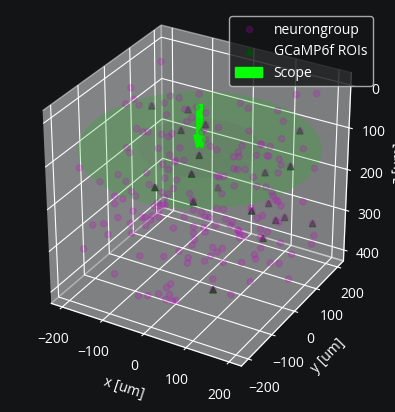

In [ ]:
i_targets, noise_focus_factor, focus_coords = scope.target_neurons_in_plane(
    ng, focus_depth=300 * b2.um, soma_radius=5 * b2.um
)
# scale noise std σ randomly to simulate biological variability
std_noise = (
    scope.sensor.sigma_noise * noise_focus_factor * rng.normal(1, 0.2, len(i_targets))
)
sim.inject(
    scope,
    ng,
    focus_depth=None,
    i_targets=i_targets,
    sigma_noise=std_noise,
    rho_rel_generator=expr_level_gen,
)

cleo.viz.plot(ng, colors=["#c500cc"], sim=sim)

We can see targets off the visualized plane, resulting from our injections at 200 and 300 μm depths, resembling a multi-plane imaging experiment.

When `focus_depth` is set to `None`, corresponding to [sculpted holographic imaging](https://www.sciencedirect.com/science/article/pii/S0959438817301940), the scope will select all neurons in the volume, or the user can specify a list of neurons to select via `i_targets` on injection.

After all targets are specified, the sensor protein must also be injected.
Doing it this way allows for efficiency: the sensor protein is only simulated for the imaged neurons.
Expression levels are as sampled previously on scope injection.

In [ ]:
scope.inject_sensor_for_targets()

## 2p stimulation configuration
Further research is needed to better quantify the relationship between 2P and the 1P action spectra, but we use a preliminary model computed in `notebooks/1p_2p_ratio.ipynb`.

In [ ]:
opsin = opto.vfchrimson_4s()
sim.inject(opsin, ng)

CLSimulator(io_processor=None, devices={Scope(name='Scope', save_history=True, sensor=GECI(name='GCaMP6f', save_history=True, model='\n            dCa/dt = -gamma * (Ca - Ca_rest) / (1 + kappa_S + kappa_B) : mmolar (clock-driven)\n            kappa_B = B_T * K_d / (Ca + K_d)**2 : 1\n\n            CaB_active = Ca_rest + b : mmolar  # add tiny bit to avoid /0\n            db/dt = beta : mmolar (clock-driven)\n            lam = 1/tau_off + 1/tau_on : 1/second\n            kap = 1/tau_off : 1/second\n            dbeta/dt = (                    # should be M/s/s\n                A * (lam - kap) * (Ca - Ca_rest)  # M/s/s\n                - (kap + lam) * beta        # M/s/s\n                - kap * lam * b    # M/s/s\n            ) : mmolar/second (clock-driven)\n            \nexc_factor = 1 : 1\n\n            dFF_baseline = 1 / (1 + (K_d / Ca_rest) ** n_H) : 1\n            dFF = exc_factor * rho_rel * dFF_max  * (\n                1 / (1 + (K_d / CaB_active) ** n_H)\n                - dFF_ba

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Action/excitation spectrum'}, xlabel='λ (nm)', ylabel='ε'>)

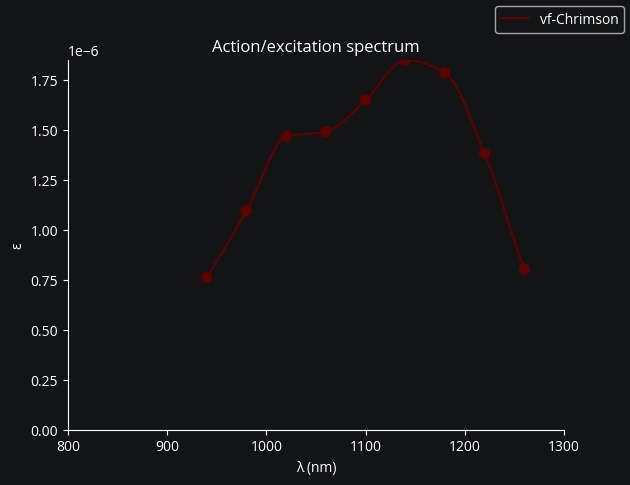

In [ ]:
cleo.light.plot_spectra(opsin, range="2p")

Now, to target these neurons with 2P laser power, we use {meth}`~cleo.light.tp_light_from_scope` to create a `Light` object with a 2P laser {class}`~cleo.light.GaussianEllipsoid` light profile centered on each of the scope's targets:

(<Figure size 640x480 with 1 Axes>,
 <Axes3D: xlabel='x [um]', ylabel='y [um]', zlabel='z [um]'>)

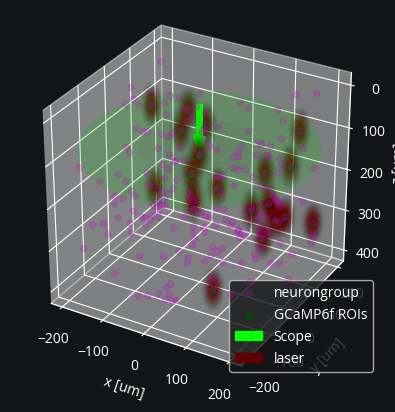

In [ ]:
laser = light.tp_light_from_scope(scope, wavelength=1060 * b2.nmeter, name="laser")
sim.inject(laser, ng)
cleo.viz.plot(ng, colors=["#c500cc"], sim=sim)

## Simulating an all-optical experiment

We'll stimulate each neuron with a different number of laser pulses and see the resulting calcium traces.

In [ ]:
from cleo.ioproc import LatencyIOProcessor

# for seeing ground-truth spikes
i_all_targets = scope.i_targets_for_neuron_group(ng)
smon = b2.SpikeMonitor(ng, record=i_all_targets)
sim.network.add(smon)

amplitude = 5 * b2.mwatt
pulse_width = 2 * b2.ms
t_interpulse = 20 * b2.ms

num_pulses = np.arange(1, scope.n + 1)
train_ends = t_interpulse * num_pulses


class IOProc(LatencyIOProcessor):
    def process(self, state_dict, t):
        t_in_cycle = t % t_interpulse
        on = (
            (0 <= t_in_cycle)
            & (t_in_cycle < pulse_width)
            & (t < (t_interpulse * num_pulses))
        )

        return {"laser": on * amplitude}, t


sim.set_io_processor(IOProc(sample_period=1 * b2.ms))

sim.reset()
tmax = 1000
sim.run(tmax * b2.ms)

INFO       No numerical integration method specified for group 'neurongroup', using method 'exact' (took 0.23s). [brian2.stateupdaters.base.method_choice]


INFO       No numerical integration method specified for group 'syn_GCaMP6f_neurongroup', using method 'euler' (took 0.02s, trying other methods took 0.09s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'syn_vf_Chrimson_neurongroup', using method 'euler' (took 0.05s, trying other methods took 0.08s). [brian2.stateupdaters.base.method_choice]


Now we'll plot the result:

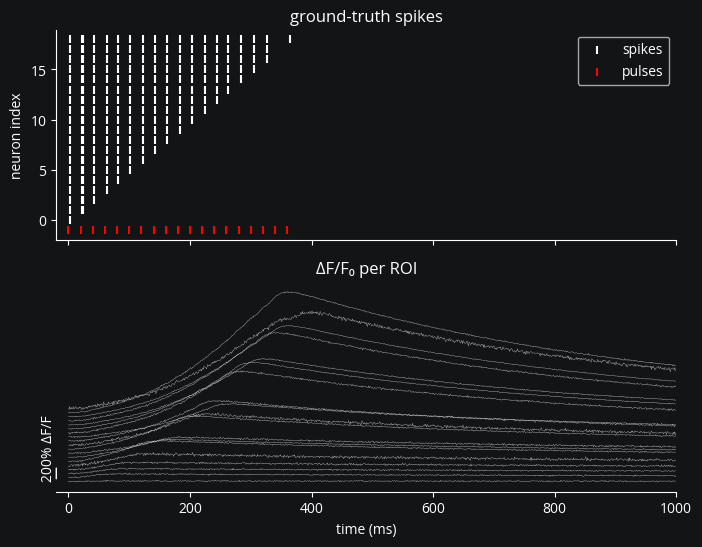

In [ ]:
sep = 0.5
n2plot = len(i_all_targets)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

spt = np.empty((0,))
spi = np.empty((0,))
for i_target, i_ng in enumerate(i_all_targets):
    single_spt = smon.t[smon.i == i_ng]
    spt = np.concatenate((spt, single_spt))
    spi = np.concatenate((spi, np.full_like(single_spt, i_target)))
ax1.scatter(spt / b2.ms, spi, marker="|", c="w", label="spikes")
t_pulse_ms = np.arange(0, num_pulses.max() * t_interpulse / b2.ms, t_interpulse / b2.ms)
ax1.scatter(
    t_pulse_ms, np.full_like(t_pulse_ms, -1), marker="|", color="r", label="pulses"
)
ax1.set(ylabel="neuron index", title="ground-truth spikes", xlim=(0, tmax))
ax1.legend()

ax2.plot(
    scope.t[:] / b2.ms,
    np.array(scope.dFF)[:, :n2plot] + sep * np.arange(n2plot),
    lw=0.2,
    c="w",
    rasterized=True,
)
y_scale = 2
y0 = 0
x0 = -20
ax2.set(xlabel="time (ms)", title="ΔF/F₀ per ROI", xlim=(x0, tmax))
ax2.annotate(
    "", xy=(x0, y0), xytext=(x0, y0 + y_scale), arrowprops=dict(arrowstyle="-")
)
ax2.annotate(
    f"{y_scale * 100}% ΔF/F", xy=(x0, y0), va="bottom", ha="right", rotation=90
)
ax2.yaxis.set_visible(False)
ax2.spines["left"].set_visible(False)

Results are as expected:
- We see one spike for every pulse, though for longer trains we might start to see missed spikes due to the opsin activation plateauing.
- If neurons were closer together, we'd expect to see some off-target effects; if there are any here, they are apparently subthreshold.
- Signal strength is proportional to the number of spikes, as expected, but varies somewhat due to heterogeneous expression.
- We also see that noise levels vary from ROI to ROI due to varying distances from the focal plane.